# On One image

In [1]:
import os
import time
import cv2
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt

In [2]:
PARENT_FOLDER = "model/cap_glasses"

c:\Users\roger\anaconda3\envs\detectron2\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=t

Class 0: cap
Class 1: glasses
Instances(num_instances=2, image_height=512, image_width=512, fields=[pred_boxes: Boxes(tensor([[ 92.4304,   0.0000, 510.5303, 206.6641],
        [125.3173, 205.5339, 407.6177, 324.6357]])), scores: tensor([1.0000, 1.0000]), pred_classes: tensor([0, 1])])
[[ 92   0 510 206]
 [125 205 407 324]]


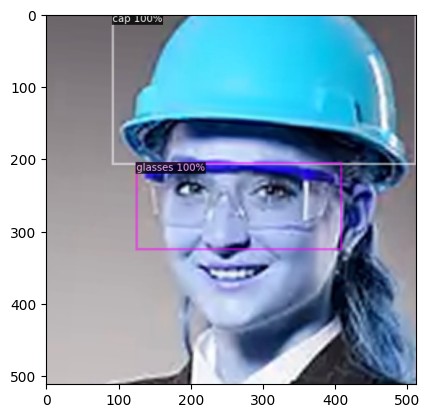

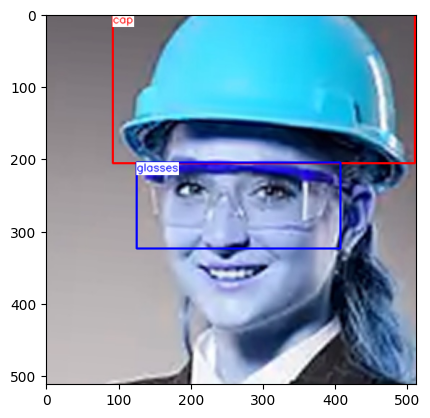

In [8]:
def set_metadata():
    # List of class names (labels) for your dataset
    class_names = ["cap", "glasses"]  

    # Define custom colors for each class (RGB values)
    thing_colors = [
        [255, 0, 0],    # Red for class 0 
        [0, 0, 255],    # Blue for class 1  
    ]

    # Create custom metadata for your dataset
    metadata = {
        "thing_classes": class_names,  # List of class names
        "thing_colors": thing_colors,  # List of colors for each class
    }

    # Register the metadata with the dataset name
    MetadataCatalog.get("face_accessories").set(**metadata)

# Function to configure the model for inference
def setup_inference(config_path, model_weights_path, score_thresh=0.3):
    cfg = get_cfg()
    cfg.set_new_allowed(True)
    cfg.merge_from_file(config_path)
    cfg.MODEL.WEIGHTS = os.path.join(model_weights_path)
    cfg.TEST.SCORE_THRESH = score_thresh  # Minimum score to keep a detection
    cfg.TEST.NMS_THRESH = 0.5    # IoU threshold for NMS                                                                                                                                                                                                                                                                                                                                                                     
    return cfg

# Function to perform inference on a single image
def inference_on_image(image_path, predictor, metadata=None, score_thresh=0.7):
    img = cv2.imread(image_path)
    outputs = predictor(img)
    instances = outputs["instances"]
    keep_indices = outputs["instances"].scores > score_thresh
    filtered_instances = instances[keep_indices]
    filtered_instances = filtered_instances.to('cpu')

    print(filtered_instances)
    print(filtered_instances.pred_boxes.tensor.int().numpy())
    print(filtered_instances.pred_classes.tensor.numpy())

    
    # Visualize results using visualizer
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
    out = visualizer.draw_instance_predictions(filtered_instances)
    
    result_image = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
    plt.imshow(result_image)
    plt.show()

    # Visualize by manual drawing on original image
    for i in range(len(filtered_instances.pred_boxes)):
        coords = filtered_instances.pred_boxes.tensor[i].int().numpy()

        # draw boxes + write text
        if filtered_instances.pred_classes[i] == 0:
            draw_color = (255, 0, 0)
            text = 'cap'
        else:
            draw_color = (0, 0, 255)
            text = 'glasses'
        
        x_start = coords[0]
        y_start = coords[1]
        cv2.rectangle(img, (x_start, y_start), (coords[2], coords[3]), draw_color, 2)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = .5
        font_thickness = 1
        text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
        text_w, text_h = text_size
        cv2.rectangle(img, (x_start, y_start), (x_start + text_w, y_start + text_h + 5), (255, 255, 255), -1)
        cv2.putText(img, text, (x_start, y_start + text_h), font, font_scale, draw_color, font_thickness, cv2.LINE_AA)

    plt.imshow(img)
    plt.show()

# Paths to your config file and trained model
config_path = PARENT_FOLDER + "/config.yaml"
model_weights_path = PARENT_FOLDER + "/model_final.pth"
image_path = "../paloma/task18/training_data/v2/valid/11007.jpg"
# image_path = "black.png"


# Set up the model for inference
cfg = setup_inference(config_path, model_weights_path)
predictor = DefaultPredictor(cfg)

# Load metadata (optional)
# metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])  # Replace with your dataset name
# Assuming you have registered your dataset (e.g., "laundry_train")
set_metadata()

metadata = MetadataCatalog.get("face_accessories")
# dataset_dicts = DatasetCatalog.get("laundry_train")
# Access the class names from the metadata
class_names = metadata.get("thing_classes", [])
# Print the class names with their corresponding indices
for idx, class_name in enumerate(class_names):
    print(f"Class {idx}: {class_name}")
    
# Perform inference
inference_on_image(image_path, predictor, metadata)

# All image in a folder

In [ ]:
# Function to perform inference and save the results
def process_images_in_folder(input_folder, output_folder, predictor, metadata):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(file_path)
            st = time.time()
            outputs = predictor(img)
            instances = outputs["instances"]
            keep_indices = outputs["instances"].scores > 0.3
            filtered_instances = instances[keep_indices]
            
            visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
            out = visualizer.draw_instance_predictions(filtered_instances.to("cpu"))
            tt = time.time() - st
            print(tt)
            result_image = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
            
            output_path = os.path.join(output_folder, f"result_{file_name}")
            cv2.imwrite(output_path, result_image)
            print(f"Saved result to {output_path}")

# Paths to your config file and trained model
config_path = PARENT_FOLDER + "/config.yaml"
model_weights_path = PARENT_FOLDER + "/model_final.pth"
input_folder = "../task18/training_data/v2/valid"  # Folder containing input images
output_folder = "output"  # Folder to save output images

# Set up the model for inference
cfg = setup_inference(config_path, model_weights_path)
predictor = DefaultPredictor(cfg)

# Set metadata
set_metadata()
metadata = MetadataCatalog.get("face_accessories")

# Process images in the input folder
process_images_in_folder(input_folder, output_folder, predictor, metadata)


c:\Users\roger\anaconda3\envs\detectron2\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=t

0.31787729263305664
Saved result to output\result_00797.jpg
0.09053802490234375
Saved result to output\result_00076.jpg
0.10362792015075684
Saved result to output\result_11734.jpg
0.0975489616394043
Saved result to output\result_00896.jpg
0.09381246566772461
Saved result to output\result_00589.jpg
0.08909773826599121
Saved result to output\result_00658.jpg
0.09388399124145508
Saved result to output\result_11577.jpg
0.08219099044799805
Saved result to output\result_10614.jpg
0.08234786987304688
Saved result to output\result_10908.jpg
0.0957648754119873
Saved result to output\result_00611.jpg
0.09603500366210938
Saved result to output\result_00313.jpg
0.09608793258666992
Saved result to output\result_00268.jpg
0.08817195892333984
Saved result to output\result_00778.jpg
0.0809319019317627
Saved result to output\result_00992.jpg
0.09678006172180176
Saved result to output\result_00242.jpg
0.23271799087524414
Saved result to output\result_10793.jpg
0.07518887519836426
Saved result to output\